MMODS Projection outcomes/objectives:

The county executive has indicated they are interested in weighing the trade-offs among a number of outcomes, including the impact of the disease on public health, hospital resources, and the local economy. To reflect these objectives, we ask participating modeling groups to address 5 outcomes (metrics):

1. cumulative number of infected individuals through November 15
2. cumulative number of deaths through November 15
3. peak hospitalizations through November 15
4. probability of a new local outbreak (more than 10 new cases/day) before November 15
5. total number of days workplaces closed through November 15

Interventions:
In this first exercise, we will only consider relaxation related to workplaces. We request that you provide model projections for the following 4 intervention scenarios:

1. continue with current workplace and school closures until November 15 (baseline full control scenario)
2. relax current social distancing 2 weeks after peak:
3. open workplaces only (schools remain closed through November 15) 
    relax social distancing when the number of new daily cases is at 1% of peak
4. open workplaces only (schools remain closed through November 15)
    immediately relax all current restrictions on workplaces (schools remain closed through November 15)

<h1><center> REQUIRED PACKAGES & DATA </h1></center>

In [1]:
ls ../

build/                     models/            simout.dat
CompileUpdateAndRun.ipynb  niddk_covid_sicr/  test.sh
covid19.pdf                notebooks/         Times.csv
covid_sicr.egg-info/       README.md          USsimout100000.dat
data/                      requirements.txt   USsimout10000.dat
dist/                      results/           USsimout10000x.dat
Dockerfile                 run-many.py        USsimout1000.dat
fits/                      run.py             USsimout.dat
Julia/                     scripts/           US_Stuff
MANIFEST.in                setup.py


In [2]:
import pandas as pd
import io
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.stats.proportion as smp
import pylab
from scipy.optimize import curve_fit
import niddk_covid_sicr as ncs
import requests

1. Place this notebook under notebooks/
2. Create covid-sicr/data/MMODS/ and place 'applemobilitytrends-2020-06-06.csv' under
3. Create covid-sicr/fits/MMODS/ and place 'MMODSNY_US_NY.pkl' and 'MMODSMD_US_MD.pkl' under

<h1><center> FUNCTIONS </h1></center>

In [3]:
def findmaxactcase(data,scenario):
    '''Get max active cases for each draw  '''
    
    subs = 'active_cases'
    res = list(filter(lambda x: subs in x, list(data)))
    subs = ','+scenario+']'
    res1 = list(filter(lambda x: subs in x, list(data[res])))
    newdf = data[res1]

    return newdf.max(axis=1)

In [4]:
def sigmoid(x, c, x0, k):
    """Mobility fitting sigmoid function"""
    y = 1 + (c / (1 + np.exp(-k*(x-x0))))
    return y

In [5]:
def analyze_CHR(df, mostrecenttime, algorithm):
    """Calculate Case-Hospitalization Ratio
    CUMUL-based CHR = hospitalizedCumulative/positiveCumul
    INSTA-based CHR = hospitalizedCurrently/activeCurrent
    algorithm = CUMUL | INSTA
    mostrecenttime = date of interest"""
    #typePH = 'PercentHospitalizedINSTA' | 'PercentHospitalizedCUMUL'
    #typeH = 'hospitalizedCurrently' |'hospitalizedCumulative'
    #thedenom = 'active' | 'positive'
    
    print('Data from covidtracking.com')
    if algorithm == 'CUMUL':
        typePH = 'PercentHospitalizedCUMUL'
        typeH = 'hospitalizedCumulative'
        thedenom = 'positive'
        print('CUMUL-based CHR = hospitalizedCumulative/positiveCumul')
    elif algorithm == 'INSTA':
        typePH = 'PercentHospitalizedINSTA'
        typeH = 'hospitalizedCurrently' 
        thedenom = 'active'
        print('INSTA-based CHR = hospitalizedCurrently/activeCurrent')
    
    df = df[df['date']==mostrecenttime] #Slice the portion with the reported date
    numstatesreporting = len(df)        #Number of states with available reporting
    denom = int(sum(df[thedenom]))      #Active cases OR Total Positives
    hospitalized = int(sum(df[typeH]))  #Total hospitalized OR Active #Hospitalized    
    Indexminperchospitalization = df[[typePH]].idxmin()
    Indexmaxperchospitalization = df[[typePH]].idxmax()
        
    print('As of date: ' + datetime.strptime(str(mostrecenttime), '%Y%m%d').strftime('%m/%d/%Y'))
    print('Number of states with available cumulative hospitalizations data: ' + str(numstatesreporting))
    print(str(hospitalized) + ' hospitalized out of ' + str(denom) + ' positive cases')
    lower, upper = smp.proportion_confint(hospitalized, denom, alpha=0.05, method='agresti_coull')
    print('US Case hospitalization percentage: ' + 
          "{:.3f}".format(100*hospitalized/denom) + '% // 95% CI (' + "{:.3f}".format(100*lower) + 
          ', ' + "{:.3f}".format(100*upper) + ')')
        
    print('Min %Case Hospitalization: ' + 
          "{:.3f}".format(df.loc[Indexminperchospitalization,typePH].values[0]) +
          ' in ' + str(df.loc[Indexminperchospitalization,'state'].values[0]))
    print('Max %Case Hospitalization: ' + 
          "{:.3f}".format(df.loc[Indexmaxperchospitalization,typePH].values[0]) +
          ' in ' + str(df.loc[Indexmaxperchospitalization,'state'].values[0]))
    
    #Calculate distribution - Normal Approximated Binomial
    print('PDF for CHR')
    N=denom
    p=hospitalized/denom
    q=1-p
    SEM = np.sqrt(N*p*q)/N
    print('N~('+str(p)+' '+str(SEM)+')')

In [6]:
def plot_trace(param, param_name='parameter'):
  """Plot the trace and posterior of a parameter."""
  
  # Summary statistics
  mean = np.mean(param)
  median = np.median(param)
  cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
  
  # Plotting
  plt.subplot(2,1,1)
  plt.plot(param)
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(mean, color='r', lw=2, linestyle='--')
  plt.axhline(median, color='c', lw=2, linestyle='--')
  plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
  plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
  plt.title('Trace and Posterior Distribution for {}'.format(param_name))

  plt.subplot(2,1,2)
  plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
  plt.gcf().tight_layout()
  plt.legend()

In [7]:
def checkoutbreak(data,scenario):
    '''Check how many draws result with an outbreak '''
    
    outbreakcond = 10 # 10 new cases per day
    subs = 'new_cases'
    res = list(filter(lambda x: subs in x, list(data)))
    subs = ','+scenario+']'
    res1 = list(filter(lambda x: subs in x, list(data[res])))
    newdf = pd.DataFrame(data=(data[res1]>outbreakcond).astype(int), dtype=np.int8)
    
    #Find days between May 15 (54) - Nov 15 (241) if outbreak occured
    return newdf.iloc[:,54:241].sum(axis=1)>0

In [8]:
def plot_time_dependent(data,whatplot,scenario,label):
    '''Plot time dependent quantities'''
    #     whatplot = 'cum_infected'
    
    daymay15index = 56
    res = list(filter(lambda x: whatplot in x, list(data)))
    subs = ','+scenario+']'
    res1 = list(filter(lambda x: subs in x, list(data[res])))
    data = data[res1]    
    numberoftimesamples = len(data.columns)
    data.columns =  np.arange(numberoftimesamples)
    
    tempdf = data.copy()
    quantiles = tempdf.quantile([0.05, 0.95])
    tempdf['draws'] = np.arange(len(data))    
    tempdf = tempdf.melt(id_vars=['draws'])
    tempdf = tempdf.rename({'variable': 'Days', 'value': whatplot}, axis='columns')
    
    ax = sns.lineplot(x="Days", y=whatplot, err_style = 'band', ci=None, data=tempdf)
    ax.fill_between(np.arange(numberoftimesamples), quantiles.loc[0.05], quantiles.loc[0.95],
                alpha=0.2, color='b')
    plt.axvline(daymay15index, color='r', lw=2, linestyle='--')
    ax.set(xlabel='Days', ylabel=label)
    ax.set_title('Scenario '+ scenario)
    plt.show()

<h1><center> CASE HOSPITALIZATION RATE </h1></center>

In [9]:
### Update/Retrieve covid-tracking-data ###
# !git clone https://github.com/COVID19Tracking/covid-tracking-data.git
# !pwd
# %cd ../covid-tracking-data
# !git pull
# home = !pwd
# %cd ../MMODS
# !pwd
#"https://github.com/COVID19Tracking/covid-tracking-data/blob/master/data/states_daily_4pm_et.csv"
url='https://raw.githubusercontent.com/COVID19Tracking/covid-tracking-data/master/data/states_daily_4pm_et.csv'
# download = github_session.get(url).content
dfState = pd.read_csv(url, na_values = ['NA', 'no info', '.'])
dfState.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20200613,AK,654.0,71149.0,NaN,12.0,NaN,NaN,NaN,2.0,...,71803,0,0,fd7214547e7a6c8b8153a5a26cb57fa373d2653e,0,0,0,0,0,NaN
1,20200613,AL,24601.0,268651.0,NaN,622.0,2241.0,NaN,672.0,NaN,...,293252,4,39,fbbaf3e55677cc7d1eed550a654b675e362268f7,0,0,0,0,0,NaN
2,20200613,AR,11547.0,175470.0,NaN,203.0,979.0,NaN,NaN,49.0,...,187017,0,18,51267156707bdb86f0a40abe6d5a71bc07b53e10,0,0,0,0,0,NaN
3,20200613,AS,0.0,174.0,NaN,NaN,NaN,NaN,NaN,NaN,...,174,0,0,6de298564b96651ea5ba89430d7ace0132db497f,0,0,0,0,0,NaN
4,20200613,AZ,34458.0,293939.0,NaN,1412.0,3692.0,447.0,NaN,309.0,...,328397,39,70,25524dee11d0758cb69b3a22cd09636269c5dc94,0,0,0,0,0,NaN


In [10]:
dfStateSimple = dfState.copy()
dfStateSimple = dfStateSimple[['date','state','positive','recovered','hospitalizedCurrently','hospitalizedCumulative']]
dfStateSimple['active'] = dfStateSimple['positive']-dfStateSimple['recovered']
dfStateSimple.dropna(0,how='any',inplace=True)
dfStateSimple.head()

,date,state,positive,recovered,hospitalizedCurrently,hospitalizedCumulative,active
1,20200613,AL,24601.0,13508.0,622.0,2241.0,11093.0
2,20200613,AR,11547.0,7607.0,203.0,979.0,3940.0
4,20200613,AZ,34458.0,6209.0,1412.0,3692.0,28249.0
6,20200613,CO,28822.0,4184.0,274.0,5234.0,24638.0
7,20200613,CT,44994.0,7611.0,233.0,9912.0,37383.0


In [11]:
#CumulHosp/#CumulPositive
dfStateSimple["PercentHospitalizedCUMUL"] = 100*dfStateSimple['hospitalizedCumulative']/dfStateSimple['positive'] 
#InstHosp/#InstActivePos
dfStateSimple["PercentHospitalizedINSTA"] = 100*dfStateSimple['hospitalizedCurrently']/dfStateSimple['active'] 
dfStateSimple.head()

,date,state,positive,recovered,hospitalizedCurrently,hospitalizedCumulative,active,PercentHospitalizedCUMUL,PercentHospitalizedINSTA
1,20200613,AL,24601.0,13508.0,622.0,2241.0,11093.0,9.109386,5.607140
2,20200613,AR,11547.0,7607.0,203.0,979.0,3940.0,8.478393,5.152284
4,20200613,AZ,34458.0,6209.0,1412.0,3692.0,28249.0,10.714493,4.998407
6,20200613,CO,28822.0,4184.0,274.0,5234.0,24638.0,18.159739,1.112103
7,20200613,CT,44994.0,7611.0,233.0,9912.0,37383.0,22.029604,0.623278


In [12]:
dfStateSimple.to_csv('CaseHospitalizationData.csv',index=False)

In [13]:
analyze_CHR(dfStateSimple,max(dfStateSimple['date']),'CUMUL')

Data from covidtracking.com
CUMUL-based CHR = hospitalizedCumulative/positiveCumul
As of date: 06/13/2020
Number of states with available cumulative hospitalizations data: 27
178190 hospitalized out of 1039306 positive cases
US Case hospitalization percentage: 17.145% // 95% CI (17.073, 17.218)
Min %Case Hospitalization: 6.442 in ND
Max %Case Hospitalization: 23.520 in NY
PDF for CHR
N~(0.17145094899865873 0.00036970671734962683)


In [14]:
analyze_CHR(dfStateSimple,max(dfStateSimple['date']),'INSTA')

Data from covidtracking.com
INSTA-based CHR = hospitalizedCurrently/activeCurrent
As of date: 06/13/2020
Number of states with available cumulative hospitalizations data: 27
12031 hospitalized out of 748962 positive cases
US Case hospitalization percentage: 1.606% // 95% CI (1.578, 1.635)
Min %Case Hospitalization: 0.552 in NY
Max %Case Hospitalization: 11.415 in MS
PDF for CHR
N~(0.016063565307719217 0.0001452695533307537)


<h1><center> State of Georgia APPLE Mobility Data - mob(t) </h1></center> 

$$mob(t) = 1+\frac{m_{max}}{1+e^{-k\left ( t-t0 \right )}}$$

In [15]:
# SOURCE https://www.apple.com/covid19/mobility
file = '../data/MMODS/applemobilitytrends-2020-06-06.csv'
dfMOB = pd.read_csv(file, na_values = ['NA', 'no info', '.'])
dfMOBG = dfMOB[dfMOB['region']=='Georgia']
dfMOBG.index = ['Mobility']
dfMOBGA = (dfMOBG.loc[:, '2020-04-24':]/dfMOBG['2020-04-24'].values[0]).transpose()
dfMOBGA.dropna(inplace=True)
dfMOBGA.head()
# dfMOBG.to_csv('MOBGA.csv',index=False)

,Mobility
2020-04-24,1.000000
2020-04-25,0.940837
2020-04-26,0.732692
2020-04-27,0.888122
2020-04-28,0.919457


[ 0.42202531 18.57132795  0.24986545]


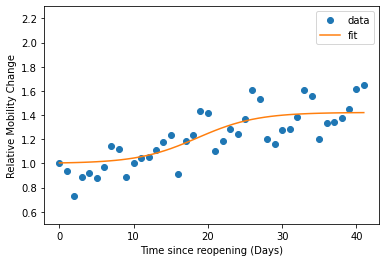

In [16]:
xdata = np.arange(len(dfMOBGA))
ydata = np.array(dfMOBGA['Mobility'])

popt, pcov = curve_fit(sigmoid, xdata, ydata)
print(popt)

x = np.linspace(0, max(xdata), 50)
y = sigmoid(x, *popt)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(x,y, label='fit')
pylab.ylim(0.5, 2.3)
pylab.legend(loc='best')
pylab.ylabel('Relative Mobility Change')
pylab.xlabel('Time since reopening (Days)')
pylab.show()

# FORECASTS

In [17]:
dfMD = ncs.extract_samples('../fits/MMODS/', '../models/', 'MMODSMD', 'US_MD', 1)
dfNY = ncs.extract_samples('../fits/MMODS/', '../models/', 'MMODSNY', 'US_NY', 1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1147860c158a0f10f3c1689254fc4fc8 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b058085f35d0d0fa4f8df18ab16c6877 NOW.


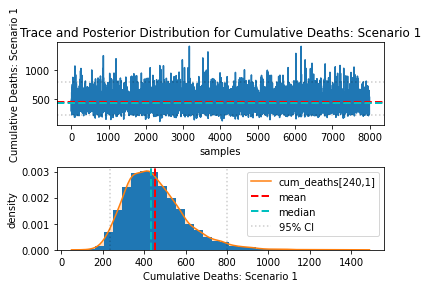

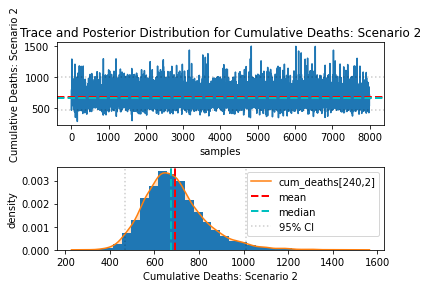

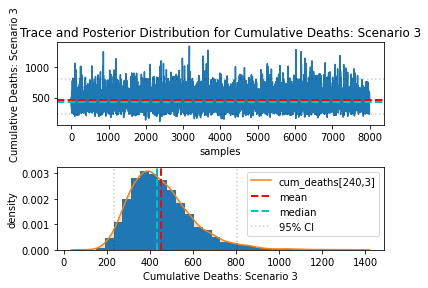

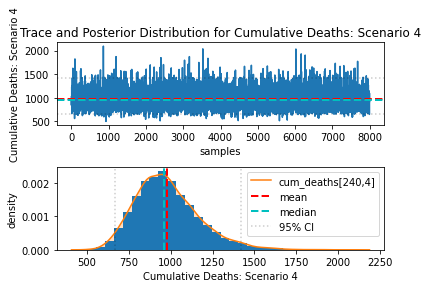

In [19]:
for scenario in range(0,4):
    plt.figure(scenario)
    plot_trace(dfNY['cum_deaths[240,'+str(scenario+1)+']'], 
               param_name='Cumulative Deaths: Scenario ' + str(scenario+1))

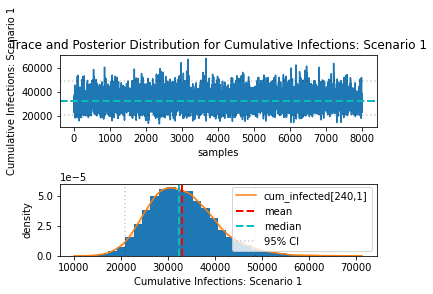

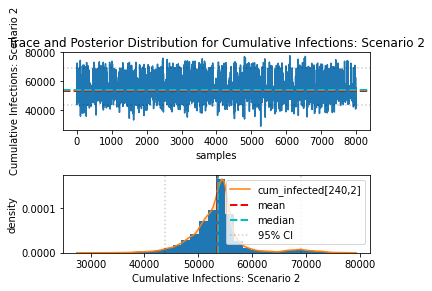

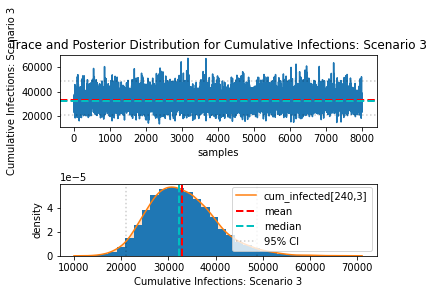

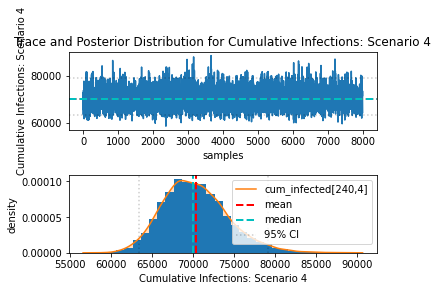

In [20]:
for scenario in range(0,4):
    plt.figure(scenario)
    plot_trace(dfNY['cum_infected[240,'+str(scenario+1)+']'], 
               param_name='Cumulative Infections: Scenario ' + str(scenario+1))

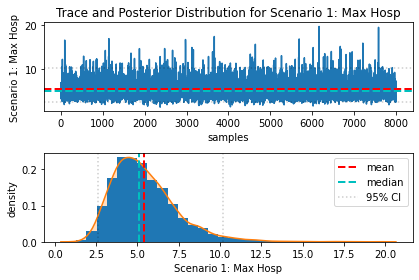

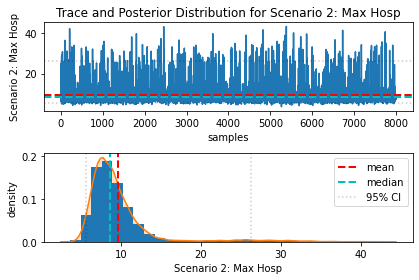

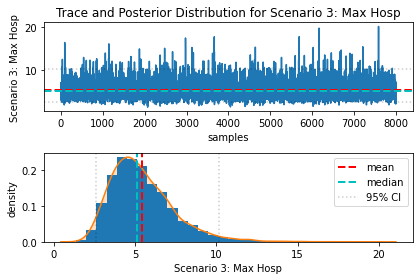

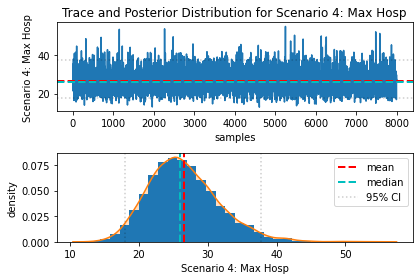

In [21]:
for scenario in range(0,4):
    plt.figure(scenario)
    CHR = 0.01865 #Case-Hospitalization Ratio
    plot_trace(findmaxactcase(dfNY,str(scenario+1))*CHR, 
               param_name='Scenario '+str(scenario+1)+': Max Hosp')

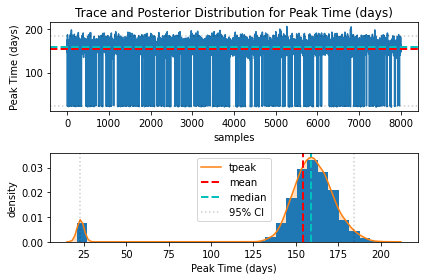

In [22]:
# FOR SCENARIO 2 we had to define the peak time
# Here we show that starting from Mar 20.
plot_trace(dfNY['tpeak'], param_name='Peak Time (days)')

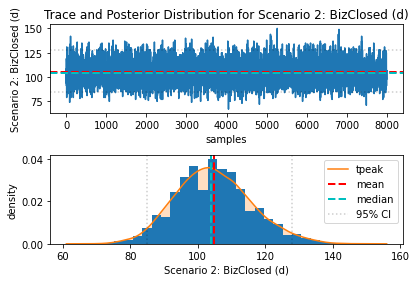

In [23]:
BizClosed = dfNY.copy()
BizClosed = BizClosed[(dfNY['tpeak']-56) >= 0]
plot_trace(BizClosed['tpeak']-56, param_name='Scenario 2: BizClosed (d)')

In [24]:
for scenario in range(1, 5):
    data = dfNY
    result = checkoutbreak(data,str(scenario))
    print('For scenario '+str(scenario)+', '+str(sum(result.astype(int))) + ' draws out of ' + str(len(result)) + ' resulted with an outbreak.')

For scenario 1, 8000 draws out of 8000 resulted with an outbreak.
For scenario 2, 8000 draws out of 8000 resulted with an outbreak.
For scenario 3, 8000 draws out of 8000 resulted with an outbreak.
For scenario 4, 8000 draws out of 8000 resulted with an outbreak.


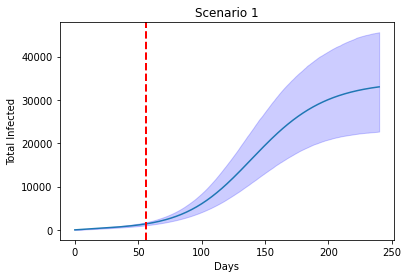

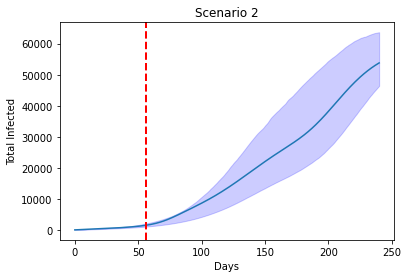

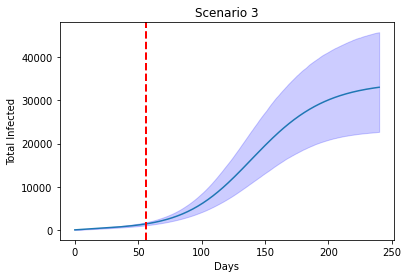

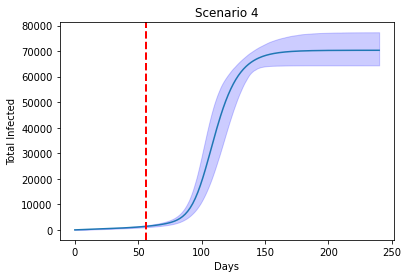

In [25]:
for scenario in range(1, 5):
    plot_time_dependent(dfNY,'cum_infected',str(scenario),'Total Infected')

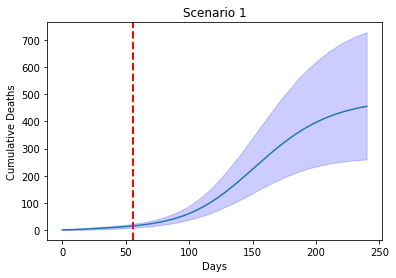

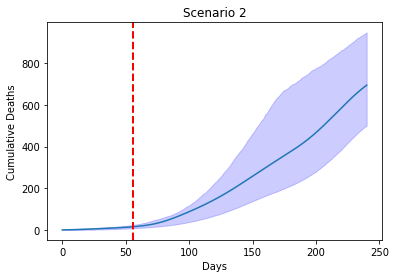

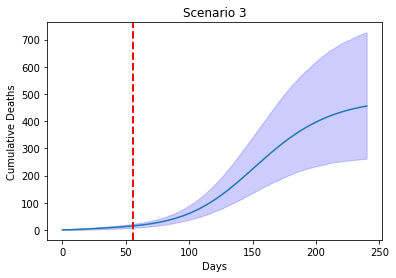

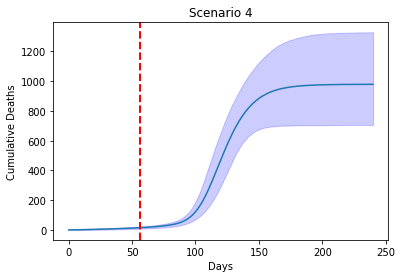

In [26]:
for scenario in range(1, 5):
    plot_time_dependent(dfNY,'cum_deaths',str(scenario),'Cumulative Deaths')

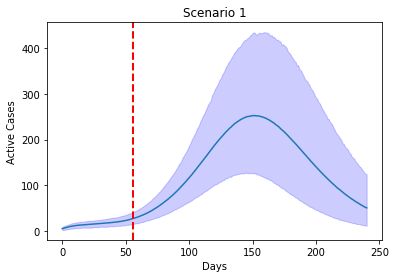

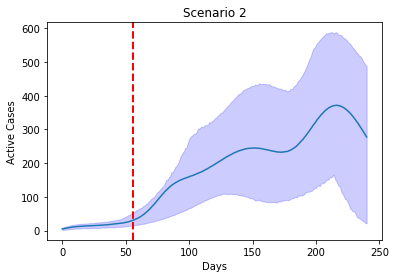

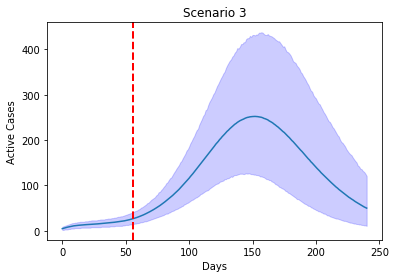

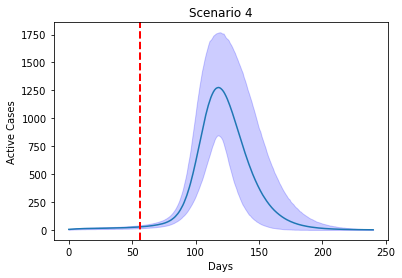

In [27]:
for scenario in range(1,5):
    plot_time_dependent(dfNY,'active_cases',str(scenario),'Active Cases')